In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import stheno.torch as stheno

#import convcnp.data
from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, init_sequential_weights, to_multiple
from convcnp.architectures import SimpleConv, UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
#import mogptk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [3]:

import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18


plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

sotonmet['Date']## preparation dataset: bramblemet
### checked working but exploration quite not fitted well

In [6]:
#sotonmet['Date'],
#sotonmet['Time']
#mid_date = '2020-07-20'
#targeted = pd.to_datetime(mid_date, format='%d/%m/%Y')
#targeted

In [7]:
# bramblemet = pd.read_csv('data/bramblemet/bramblemet.csv.gz', compression='gzip', low_memory=False)
# bramblemet['Date'] = pd.to_datetime(bramblemet['Date'] + ' ' + bramblemet['Time'], format='%d/%m/%Y %H:%M')
   

In [8]:
cols = ['bramblemet','cambermet','chimet','sotonmet']

In [9]:
from collections import OrderedDict

# start_date = '2020-06-02'
# end_date = '2020-06-07' #work doen checked

start_date = '2020-07-01'
mid_date = '2020-07-20'
end_date = '2020-07-30'

print('Loading Bramble')
bramblemet = pd.read_csv('data/bramblemet/bramblemet.csv.gz', compression='gzip', low_memory=False)
bramblemet['Date'] = pd.to_datetime(bramblemet['Date'] + ' ' + bramblemet['Time'], format='%d/%m/%Y %H:%M')
bramblemet = bramblemet.drop(columns=['Time'])
bramblemet = bramblemet.loc[(bramblemet['Date'] >= start_date) & (bramblemet['Date'] < end_date)]

print('Loading Camber')
cambermet = pd.read_csv('data/bramblemet/cambermet.csv.gz', compression='gzip', low_memory=False)
cambermet['Date'] = pd.to_datetime(cambermet['Date'] + ' ' + cambermet['Time'], format='%d/%m/%Y %H:%M')
cambermet = cambermet.drop(columns=['Time'])
cambermet = cambermet.loc[(cambermet['Date'] >= start_date) & (cambermet['Date'] < end_date)]

print('Loading Chi')
chimet = pd.read_csv('data/bramblemet/chimet.csv.gz', compression='gzip', low_memory=False)
chimet['Date'] = pd.to_datetime(chimet['Date'] + ' ' + chimet['Time'], format='%d/%m/%Y %H:%M')
chimet = chimet.drop(columns=['Time'])
chimet = chimet.loc[(chimet['Date'] >= start_date) & (chimet['Date'] < end_date)]

print('Loading Soton')
sotonmet = pd.read_csv('data/bramblemet/sotonmet.csv.gz', compression='gzip', low_memory=False)
sotonmet['Date'] = pd.to_datetime(sotonmet['Date'] + ' ' + sotonmet['Time'], format='%d/%m/%Y %H:%M')
sotonmet = sotonmet.drop(columns=['Time'])
sotonmet = sotonmet.loc[(sotonmet['Date'] >= start_date) & (sotonmet['Date'] < end_date)]







normalize=True
dataset_dict = OrderedDict()
# dataset_dict['bramblemet'] = bramblemet
# dataset_dict['cambermet'] = cambermet
# dataset_dict['chimet'] = chimet
# dataset_dict['sotonmet'] = sotonmet
dataset_dict[0] = bramblemet
dataset_dict[1] = cambermet
dataset_dict[2] = chimet
dataset_dict[3] = sotonmet

num_channels = 4
#default_round = 100000000000
default_round = 100000000000
time_scale = 60*24 #5minute per obesration
#time_scale = 60 #5minute per obesration

for ith_dict in dataset_dict:
    x = dataset_dict[ith_dict]['Date'].to_numpy().astype('int')/default_round
    y = dataset_dict[ith_dict]['DEPTH'].to_numpy(dtype=np.float32)    
    #dataset_dict[ith_dict] = 
    x,y = np.asarray(x,dtype=np.float32),np.asarray(y,dtype=np.float32)
    dataset_dict[ith_dict] = {}
    dataset_dict[ith_dict]['x'] = x
    dataset_dict[ith_dict]['y'] = y
    
    
    x0 = dataset_dict[ith_dict]['x'][0]
    if normalize == True:
        dataset_dict[ith_dict]['x'] -= x0 
        dataset_dict[ith_dict]['x'] /= time_scale
        
        dataset_dict[ith_dict]['ymean'] = dataset_dict[ith_dict]['y'].mean()
        dataset_dict[ith_dict]['ystd'] = dataset_dict[ith_dict]['y'].std() 
        dataset_dict[ith_dict]['y'] = (dataset_dict[ith_dict]['y'] - dataset_dict[ith_dict]['ymean'])/dataset_dict[ith_dict]['ystd']

    idx = np.argsort(dataset_dict[ith_dict]['x'])
    dataset_dict[ith_dict]['x'] = dataset_dict[ith_dict]['x'][idx]
    dataset_dict[ith_dict]['y'] = dataset_dict[ith_dict]['y'][idx]        
        
# split train and target 
#n_time_split = (pd.Timestamp(mid_stamp) - pd.Timestamp(start_stamp))/ pd.Timedelta(hours=1)
# n_time_split = pd.to_datetime(mid_date, format='%Y/%m/%d').to_numpy().astype('int')
# n_time_split = (n_time_split - x0)/default_round
# if normalize == True:
#     n_time_split /= time_scale
        
        
print('')
for ith_key in dataset_dict:
    print(ith_key,len(dataset_dict[ith_key]['x']))



Loading Bramble
Loading Camber
Loading Chi
Loading Soton

0 1693
1 2303
2 2299
3 2260


In [13]:
# #n_time_split = pd.to_datetime(mid_date, format='%Y/%m/%d').to_numpy().astype('int')/default_round
# #n_time_split
# #x0
# n_time_split
# time_scale

In [14]:
def nparray2tensor(context_x,context_y,target_x,target_y):
    return torch.tensor(context_x).float(),\
           torch.tensor(context_y).float(),\
           torch.tensor(target_x).float(),\
           torch.tensor(target_y).float()



def get_index_new(dataset_dict,n_time_split):
    time_dict_index = {}    
    for ith_channel in dataset_dict:
        train_idx = np.where( (dataset_dict[ith_channel]['x'] <= n_time_split))[0]
        test_idx = np.where( ~ (dataset_dict[ith_channel]['x'] <= n_time_split))[0]
        full_idx = np.arange(len(dataset_dict[ith_channel]['x']))
        time_dict_index[ith_channel] = {'train_idx':train_idx,'test_idx':test_idx,'full_idx':full_idx}    
    return time_dict_index



def prepare_batch_new(dataset_dict, time_dict_index , nbatch = 32,batch_npoints=(64,64), intrain = True, forfig = False):
    context_x,context_y = [],[]
    target_x,target_y = [],[]
    full_x,full_y = [],[]
    
    #n_points = len(x)
    #time_dict_index = get_index(dataset_dict,test_option = test_option,test_len=test_len)
    
    for _ in range(nbatch):

        i_context_x,i_context_y = [],[]
        i_target_x,i_target_y = [],[]
        i_full_x,i_full_y = [],[]
        for ith_channel in time_dict_index:
            if intrain and not forfig:
                sampled_c_idx = np.random.choice(time_dict_index[ith_channel]['train_idx'],min(batch_npoints[0],len(time_dict_index[ith_channel]['train_idx'])))
                sampled_t_idx = np.random.choice(time_dict_index[ith_channel]['train_idx'],min(batch_npoints[1],len(time_dict_index[ith_channel]['train_idx'])))
                

            if not intrain and not forfig:                
                sampled_c_idx = np.random.choice(time_dict_index[ith_channel]['test_idx'],min(batch_npoints[0],len(time_dict_index[ith_channel]['test_idx'])))
                sampled_t_idx = np.random.choice(time_dict_index[ith_channel]['test_idx'],min(batch_npoints[1],len(time_dict_index[ith_channel]['test_idx'])))
                #ith_context_x,ith_context_y = dataset_dict[ith_channel]['x'][sampled_c_idx],dataset_dict[ith_channel]['y'][sampled_c_idx]
                #ith_target_x,ith_target_y = dataset_dict[ith_channel]['x'][sampled_t_idx],dataset_dict[ith_channel]['y'][sampled_t_idx]        
                
                
            if not intrain and forfig:                
                sampled_c_idx = np.random.choice(time_dict_index[ith_channel]['full_idx'],min(batch_npoints[0],len(time_dict_index[ith_channel]['full_idx'])))
                sampled_t_idx = np.random.choice(time_dict_index[ith_channel]['full_idx'],min(batch_npoints[1],len(time_dict_index[ith_channel]['full_idx'])))
                
                                
                
            sampled_c_idx.sort() 
            sampled_t_idx.sort()                 
            ith_context_x,ith_context_y = dataset_dict[ith_channel]['x'][sampled_c_idx],dataset_dict[ith_channel]['y'][sampled_c_idx]
            ith_target_x,ith_target_y = dataset_dict[ith_channel]['x'][sampled_t_idx],dataset_dict[ith_channel]['y'][sampled_t_idx]        

        
                #print('ith_target_x,ith_target_y ')
                #print(ith_target_x,ith_target_y )

            i_context_x.append(ith_context_x)
            i_context_y.append(ith_context_y) 
            i_target_x.append(ith_target_x)
            i_target_y.append(ith_target_y) 
            #i_full_x.append(dataset_dict[ith_channel]['x'])
            #i_full_y.append(dataset_dict[ith_channel]['y']) 



        i_context_x,i_context_y = np.asarray(i_context_x).T,np.asarray(i_context_y).T
        i_target_x,i_target_y = np.asarray(i_target_x).T,np.asarray(i_target_y).T   
        i_full_x,i_full_y = np.asarray(i_full_x).T,np.asarray(i_full_y).T   

        #print(i_full_x.shape)
        
        #print(i_context_x.shape,i_context_y.shape,i_target_x.shape,i_target_y.shape)
        
        context_x.append( i_context_x )
        context_y.append( i_context_y )
        target_x.append( i_target_x  )
        target_y.append( i_target_y )
        #full_x.append(i_full_x)
        #full_y.append(i_full_y)
    
    #print(type(context_x))        

    context_x = np.asarray(context_x,dtype=np.float32)
    context_y = np.asarray(context_y,dtype=np.float32)
    target_x = np.asarray(target_x,dtype=np.float32)
    target_y = np.asarray(target_y,dtype=np.float32)
    full_x = np.asarray(full_x,dtype=np.float32)
    full_y = np.asarray(full_y,dtype=np.float32)
    
    #context_x = torch.tensor(context_x).float()
    #context_y = torch.tensor(context_y).float()
    #target_x = torch.tensor(target_x).float()
    #target_y = torch.tensor(target_y).float()
    
    context_x,context_y,target_x,target_y = nparray2tensor(context_x,context_y,target_x,target_y)
    return context_x,context_y,target_x,target_y


In [15]:
#context_x

In [16]:
# idx = int(len(dataset_dict[0]['x'])*0.66)
# n_time_split = dataset_dict[0]['x'][idx]
n_time_split = 3.0
xlim_ = [0,5]

context_x.shape,context_y.shape,target_x.shape,target_y.shape
torch.Size([3, 50, 4]) torch.Size([3, 50, 4]) torch.Size([3, 100, 4]) torch.Size([3, 100, 4])


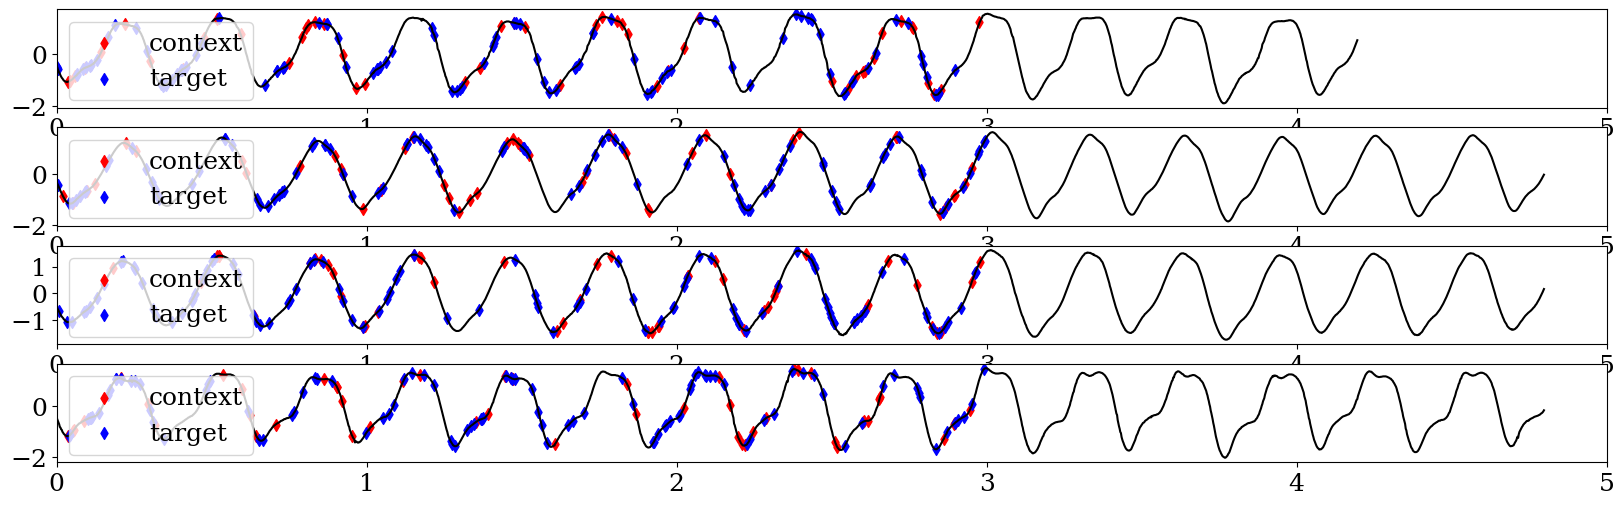

----------------------------------------------------------------------------------------------------






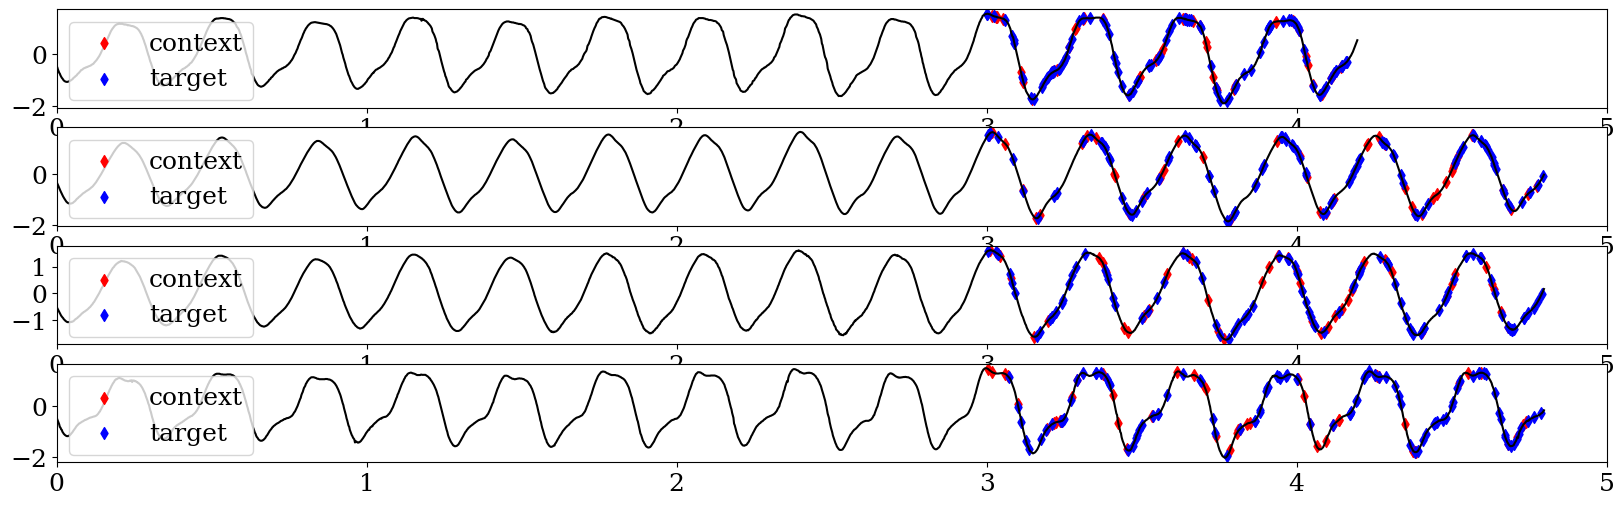

----------------------------------------------------------------------------------------------------






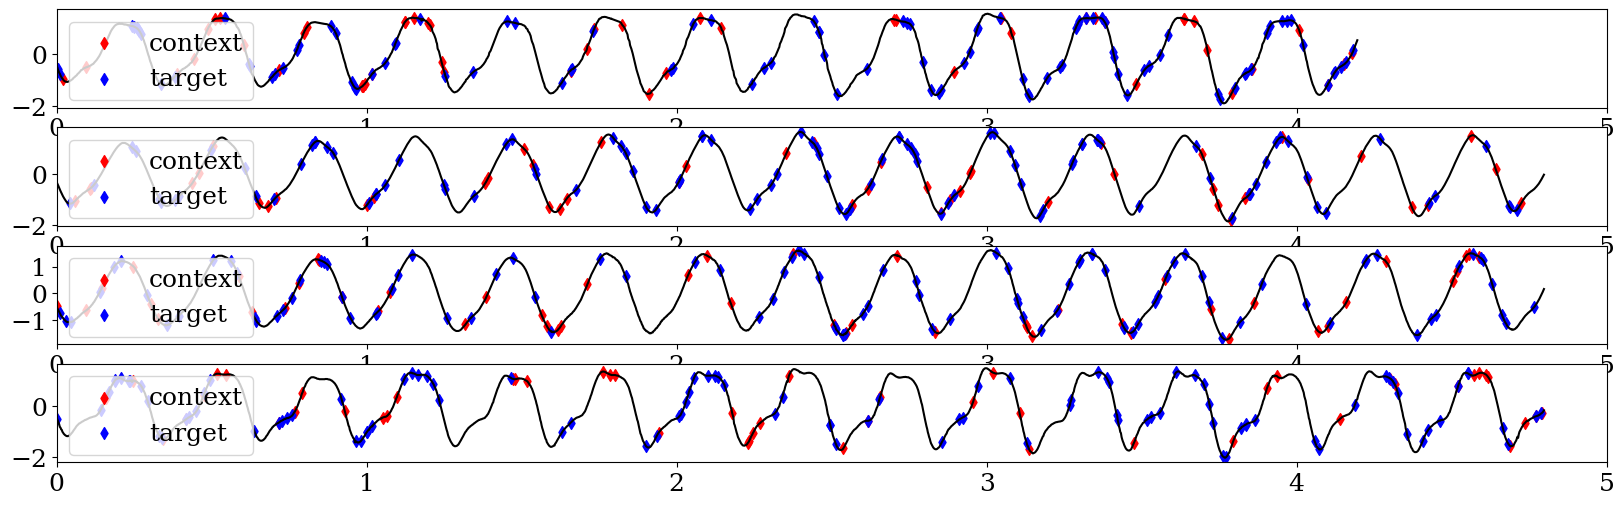

In [17]:
#time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=48)
#context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,100), intrain = True)
time_dict_index = get_index_new(dataset_dict,n_time_split)
context_x,context_y,target_x,target_y= prepare_batch_new(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,100), intrain = True)
print('context_x.shape,context_y.shape,target_x.shape,target_y.shape')
print(context_x.shape,context_y.shape,target_x.shape,target_y.shape)

plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d',label='context')
    #plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d',label='target')
    #plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k')
    plt.legend(loc='upper left',fontsize=18)    
    plt.xlim(xlim_)
plt.show()
print('-'*100)
print('\n'*3)
    
    
    
#context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,50), intrain = False)
context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,100), intrain = False)

plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d',label='context')
    #plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d',label='target')
    #plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k')
    plt.legend(loc='upper left',fontsize=18)    
    plt.xlim(xlim_)
    
plt.show()
print('-'*100)
print('\n'*3)



#context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,50), intrain = False)
context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,100), intrain = False, forfig=True)

plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d',label='context')
    #plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d',label='target')
    #plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k')
    plt.legend(loc='upper left',fontsize=18)    
    plt.xlim(xlim_)
    
plt.show()


## used num dataset

In [18]:
#len(dataset_dict[0]['x']),len(dataset_dict[1]['x']),len(dataset_dict[2]['x']),len(dataset_dict[3]['x'])
for j in range(num_channels):
    print(len(time_dict_index[j]['train_idx']),len(time_dict_index[j]['test_idx']),len(time_dict_index[j]['train_idx'])+len(time_dict_index[j]['test_idx']))

1155 538 1693
1441 862 2303
1439 860 2299
1413 847 2260


In [19]:
# from test_baseline import Convcnp,compute_loss_baseline
# from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# #from test_correlatenp import  CGP_Convnp,compute_loss_gp        
# from test_mocorrelatenp import  CGP_Convnp,compute_loss_gp        

from test_baseline import Convcnp,compute_loss_baseline
from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
from test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()




num_channels = 4
nsamples_latent=10
#nsamples_gp = 10
nsamples_gp = 10



lr = 0.001
weight_decay=1e-4
#cnntype = 


init_lengthscale = 0.1
#init_lengthscale = 0.5
#def get_model(modelname='gp'):        
def get_model(modelname='gpdep',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=num_channels,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_latent,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    #if modelname == 'gp_ind':
    if modelname == 'gpind':        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    #if modelname == 'gp_dep':
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
      
    return model,opt,lossfun


In [20]:
def merge_allset_1d(xc,yc,xt,yt):
    xct = torch.cat([xc,xt],dim=1)
    yct = torch.cat([yc,yt],dim=1)
    xct,s_idx =torch.sort(xct,dim=1)

    if len(xc.size()) == 3:
        yct = torch.gather(yct,1,s_idx)    
    if len(xc.size()) == 4:
        yct = torch.gather(yct,1,s_idx[:,:,0,:])
    return xct,yct
    

    
    
    
#reglamda=1.
proposed_model_list = ['gpind','gpdep']
#def train_epochs_with_dict(set_dict_epoch,model,opt,lossfun,trainmodel='convcnp',trainprogress_ratio = 0.0):
def train_epochs(dataset_dict,time_dict_index,model,opt,lossfun,ntask=4,nbatch=32,ncontext=32,ntarget=2*32):
    
    model.train()
    likelihoods = []
    
    #ntask = set_dict_epoch['context_x'].size(0)
    for _ in range(ntask):
                
        #context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        #target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]

        
        
#         context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, 
#                                                               time_dict_index , 
#                                                               nbatch = nbatch,
#                                                               batch_npoints=(ncontext ,ntarget), 
#                                                               intrain = True)
        #ncontext_rntarget_r 
        context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
                                                                  time_dict_index , 
                                                                  nbatch = nbatch,
                                                                  batch_npoints=(ncontext ,ntarget), 
                                                                  intrain = True)        
        
        #context_x,context_y,target_x,target_y = nparray2tensor(context_x,context_y,target_x,target_y)        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:        
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)        
        
        target_x,target_y = merge_allset_1d(context_x,context_y,target_x,target_y)

        #predict & train models
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())    
        obj = lossfun( y_mean,y_std, target_y.cuda())

        
        
        obj.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),max_grad_norm)
        opt.step()
        opt.zero_grad()
        
        #losses.append(obj.item())
        likelihoods.append(obj.cpu().data.numpy())        
        
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       




#def validate_epochs(dataset_dict,time_dict_index,model,ntask=128,nbatch=32,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True):
def validate_epochs(dataset_dict,time_dict_index,model,lossfun,ntask=128,nbatch=4,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True):

    # large is better 
    model.eval()
    likelihoods = []
    
    #ntask = set_dict_epoch['context_x'].size(0)    
    for _ in range(ntask):        
        
        #context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        #target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]        
        
#         context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, 
#                                                               time_dict_index , 
#                                                               nbatch = nbatch,
#                                                               batch_npoints=(ncontext ,ntarget), 
#                                                               intrain = intrain)
        context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
                                                                  time_dict_index , 
                                                                  nbatch = nbatch,
                                                                  batch_npoints=(ncontext ,ntarget), 
                                                                  intrain = intrain)

         
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)
                    
        
        
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
        #obj = -compute_nll( y_mean,y_std, target_y.cuda())
        obj = -lossfun( y_mean,y_std, target_y.cuda())

                    
        #if trainmodel in base_model_list:
        #    obj = -compute_nll( y_mean,y_std, target_y.cuda())
        #if trainmodel in latent_model_list:
        #    obj = -compute_nll_latent( y_mean, y_std, target_y.cuda())            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       
    


    

## train model 

In [82]:
#-------------------------------------------
# train
#------------------------------------------
nepochs=2000
ntask,nbatch,ncontext,ntarget = 1,4,20,100
ntask_v,nbatch_v,ncontext_v,ntarget_v = 5,4,20,100



#-------------------------------------------
# build the model
#------------------------------------------
# #model_type = 'convcnp'
# model_type = 'anp'
# #model_type = 'propose_v3'
# model,opt = build_model(model_type=model_type)
# model.num_params




#modelname = 'base'
#modelname = 'baselatent'
#modelname = 'gpind'
modelname = 'gpdep'


cnntype = 'shallow'
#cnntype = 'deep'

saved_modelparam_path = './param_bramblemet/{}_{}.pth'.format(modelname,cnntype)



model,opt,lossfun = get_model(modelname=modelname,cnntype=cnntype)
model.num_params
model




#-------------------------
# Task
#-------------------------
#ncontext,ntarget = 20,100
#time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=128) #split context,target index region
#time_dict_index = get_index(dataset_dict,test_type = 'extra',test_len=128) #split context,target index region

#pred_day = 128*4
#time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=256) #split context,target index region
#time_dict_index = get_index(dataset_dict,test_type = 'extra',test_len=256) #split context,target index region

# time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=pred_day) #split context,target index region
# time_dict_index = get_index(dataset_dict,test_type = 'extra',test_len=pred_day ) #split context,target index region

DCGP_Convnp(
  (cnn): cnn_shallow(
    (cnn): Sequential(
      (0): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): ReLU()
      (6): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (7): ReLU()
      (8): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (gpsampler): Multioutput_GPsampler(
    (kernel): SM_kernel()
  )
  (gp_linear): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (cnn_linear): Sequential(
    (0): Linear(in_features=8, out_features=20, bias=True)
  )
  (smoother): ConvDeepset(C_in=1, C_out=1, )
  (pred_linear): Sequential(
    (0): Linear(in_features=20, out_features=8, bias=True)
  )
)

In [83]:
#model.gpsampler.kernel.prepare_cross_params()

In [31]:
figsiz_ = (10,2.*4)
#bidx=4
wspace_ = 0.5
hspace_ = 0.01
fontsiz_ = 18
ylim_ = [-2.5,2.5]
yticks_ = [-2,0,2]

In [84]:
# context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(25,100), intrain = False)
# context_x = context_x.squeeze().cpu().data.numpy()
# context_y = context_y.squeeze().cpu().data.numpy()
# target_x = target_x.squeeze().cpu().data.numpy()
# target_y = target_y.squeeze().cpu().data.numpy()




# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= wspace_, hspace= hspace_)

# for j in range(num_channels):
#     #plt.subplot(nchannels//2,2,j+1)
#     plt.subplot(num_channels,1,j+1 )
    
#     #imputation region
#     #xb = target_x[:,j].min()+0.1,target_x[:,j].max()+0.1
#     s_idx,e_idx = time_dict_index[j]['target_idx'][0],time_dict_index[j]['target_idx'][-1]
#     xb = dataset_dict[j]['x'][s_idx], dataset_dict[j]['x'][e_idx]
#     plt.axvspan(xmin = xb[0],xmax = xb[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.4)

#     #dataset
#     plt.scatter(context_x[:,j],context_y[:,j],color = 'b',label = 'context',s=50)
#     plt.scatter(target_x[:,j],target_y[:,j],color = 'r',label = 'target',s=50)
#     plt.plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=2.5)
    

# #     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
# #     plt.fill_between(target_x[:,j],
# #                      y_mean[:,j] + 2 * y_std[:,j],
# #                      y_mean[:,j] - 2 * y_std[:,j],
# #                      color='tab:blue', alpha=0.4)

# #     if len(y_mean.shape)==2:
# #         plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
# #         plt.fill_between(target_x[:,j],
# #                          y_mean[:,j] + 2 * y_std[:,j],
# #                          y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=0.4)

        
# #     if len(y_mean.shape)==3:
# #         for kk in range(2):
# #             plt.plot(target_x[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=3.0,label='model')
# #             plt.fill_between(target_x[:,j],
# #                              y_mean[kk,:,j] + 2 * y_std[kk,:,j],
# #                              y_mean[kk,:,j] - 2 * y_std[kk,:,j],
# #                              color='tab:blue', alpha=0.4)
        

#     if j == num_channels:
#         plt.xticks(np.linspace(0,3.,6),np.linspace(0,3.,6))
#     else:
#         plt.xticks([])

#     plt.ylim(ylim_)
#     plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
#     #plt.xlim(xlim_)
#     plt.yticks(yticks_,fontsize=fontsiz_-2)

#     if j == 0:
#         leg = plt.legend(loc = 'upper left',bbox_to_anchor=(.05,1.50),fontsize=fontsiz_,ncol=4,handlelength= 1.5, columnspacing =1.5)
#         #leg= plt.legend(bbox_to_anchor=(.52,1.37),fontsize = fontsiz-1, ncol = 6 ,handlelength= 1.5, columnspacing =1.5,) 

#         for ii in leg.legendHandles:
#             ii.set_linewidth(2)      


# fig.tight_layout()    
# #plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
# plt.show()
# #'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [87]:
saved_modelparam_path

'./param_bramblemet/gpdep_shallow.pth'

## evaluate metric

In [90]:

path1 = saved_modelparam_path 
#model,_ = build_model(model_type=model_type)
model,_,lossfun = get_model(modelname=modelname,cnntype=cnntype)

load_dict = torch.load(path1)
model.load_state_dict(load_dict['state_dict'])   



#ntask = 256
modelspec = '{}_{}_nsample{}_initl{}.pth'.format(modelname,cnntype,nsamples_gp,init_lengthscale )
ntask,nbatch,_,ntarget = 64,4,_,100
ncontext_list = [15,20,30,50]

results_list = []
for ncontext in ncontext_list:
    #val_loss_m,val_loss_s = validate_epochs(dataset_dict,time_dict_index,model,ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget, intrain=False)
    val_loss_m,val_loss_s = validate_epochs(dataset_dict,time_dict_index,model,lossfun,ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget , intrain=False)
    results_list.append((val_loss_m,val_loss_s))
#val_loss_m,val_loss_s

RuntimeError: torch.linalg.cholesky: For batch 7: U(16,16) is zero, singular U.

In [89]:
# print('ncontext_list')
# print(ncontext_list)
print('modelspec: {} \t {}'.format(modelspec,results_list))

modelspec: gpdep_shallow_nsample10_initl0.1.pth 	 []


In [ ]:
modelspec: base_shallow_nsample10_initl0.1.pth 	 [(-206.86, 9.14), (-104.96, 6.01), (-98.05, 5.72), (-173.12, 6.67)]


In [91]:
#ntask = 256
ntask,nbatch,ncontext,ntarget = 256,4,30,100
#val_loss_m,val_loss_s = validate_epochs(dataset_dict,time_dict_index,model,ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget, intrain=False)
val_loss_m,val_loss_s = validate_epochs(dataset_dict,time_dict_index,model,lossfun,ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget , intrain=False)

val_loss_m,val_loss_s

RuntimeError: torch.linalg.cholesky: For batch 12: U(24,24) is zero, singular U.

In [92]:
#Model averages a log likelihood of -47.28 on unseen tasks.
saved_model_path = './fig/exp2_bram/'
datatype = 'bram'

## prediction

In [138]:
#----------------------------------
# small datset
#----------------------------------
#ncontext,ntarget = 50,200
ncontext,ntarget = 20,100

#context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = True)
#context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False)
context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False, forfig=True)

#context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False)


#----------------------------------
# large datset
#----------------------------------
#context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(50,100), intrain = False)
#model.eval()
#y_mean, y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())

#max_x = 5.1
max_x = 6.1

model.eval()
full_x = torch.linspace(0,max_x,3*ntarget)[None,:].repeat(num_channels,1).T
full_x = full_x[None,:,:]


if model.modelname in proposed_model_list and len(context_x.size()) == 3:        
    context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)        
    full_x = full_x.unsqueeze(dim=-2)     




y_mean, y_std = model(context_x.cuda(),context_y.cuda(),full_x.cuda())





#y_mean, y_std = predict_cross(context_x,context_y,target_x,target_y)
y_mean = y_mean.squeeze().cpu().data.numpy()
y_std = y_std.squeeze().cpu().data.numpy()



context_x = context_x.squeeze().cpu().data.numpy()
context_y = context_y.squeeze().cpu().data.numpy()
target_x = target_x.squeeze().cpu().data.numpy()
target_y = target_y.squeeze().cpu().data.numpy()
full_x =full_x.squeeze().cpu().data.numpy()



## figures

In [154]:
figsiz_ = (11,2.5*4)
#bidx=4
wspace_ = 0.5
hspace_ = 0.25
fontsiz_ = 18

ylim_ = [-2.5,2.5]
xlim_ = [0-0.01,max_x+0.01]
#xlim_ = [10,29.1]

yticks_ = [-1,0,1]
xticks_ = list(np.arange(xlim_[0],xlim_[1],dtype=np.int))[::1]

In [155]:
#context_y

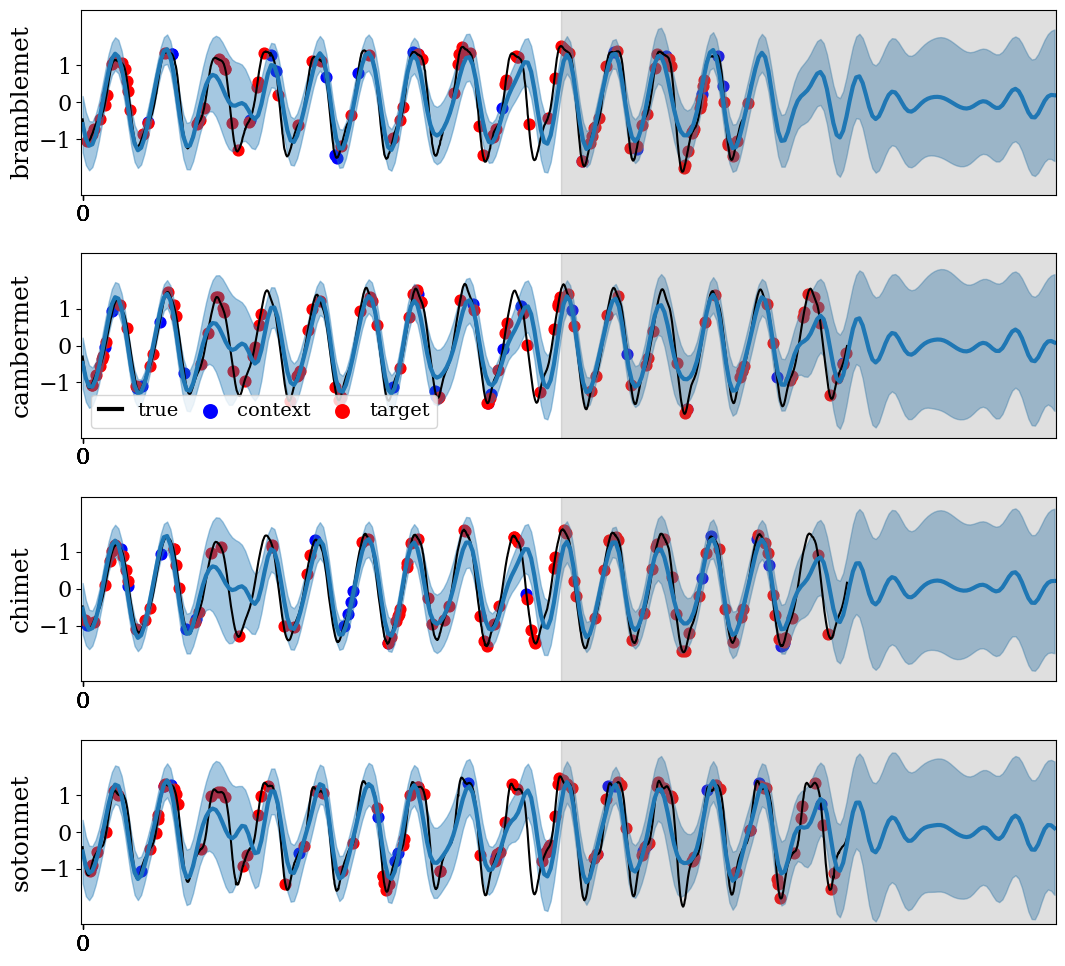

In [156]:
#cols[1] = 'Temperature'


#xlim_ = [0,220]

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= wspace_, hspace= hspace_)

for j in range(num_channels):
    #plt.subplot(nchannels//2,2,j+1)
    plt.subplot(num_channels,1,j+1)
    
    #imputation region
    #xb = target_x[:,j].min()+0.1,target_x[:,j].max()+0.1
    #s_idx,e_idx = time_dict_index[j]['target_idx'][0],time_dict_index[j]['target_idx'][-1]
    #xb = dataset_dict[j]['x'][s_idx], dataset_dict[j]['x'][e_idx]
    #plt.axvspan(xmin = n_time_split ,xmax = xlim_[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label='beyond training')
    plt.axvspan(xmin = n_time_split ,xmax = xlim_[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)

    #dataset
    plt.scatter(context_x[:,j],context_y[:,j],color = 'b',label = 'context',s=60)
    plt.scatter(target_x[:,j],target_y[:,j],color = 'r',label = 'target',s=60)
    plt.plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=1.5)
    

#     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
#     plt.fill_between(target_x[:,j],
#                      y_mean[:,j] + 2 * y_std[:,j],
#                      y_mean[:,j] - 2 * y_std[:,j],
#                      color='tab:blue', alpha=0.4)

    if len(y_mean.shape)==2:
        plt.plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0)
        plt.fill_between(full_x[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=0.4)

        
    if len(y_mean.shape)==3:
        for kk in range(1):
            plt.plot(full_x[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=3.0)
            plt.fill_between(full_x[:,j],
                             y_mean[kk,:,j] + 2 * y_std[kk,:,j],
                             y_mean[kk,:,j] - 2 * y_std[kk,:,j],
                             color='tab:blue', alpha=0.4)
        

#     if j == num_channels:
#         plt.xticks(np.linspace(0,3.,6),np.linspace(0,3.,6))
#     else:
#         plt.xticks([])
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    #plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
    plt.ylabel('{}'.format(cols[j]),fontsize=fontsiz_)
    #plt.xlim(xlim_)
    plt.yticks(yticks_,fontsize=fontsiz_-2)
    plt.xticks(xticks_,fontsize=fontsiz_-2)

    #if j == 0:
    #    leg = plt.legend(loc = 'upper left',bbox_to_anchor=(.05,1.50),fontsize=fontsiz_,ncol=5,handlelength= 1.5, columnspacing =1.5)
    #    for ii in leg.legendHandles:
    #        ii.set_linewidth(2)      

    
    if j == 1:
        leg = plt.legend(loc = 'lower left',fontsize=fontsiz_-4,ncol=5,handlelength= 1.2, columnspacing =1.0)
        for ii in leg.legendHandles:
            ii.set_linewidth(3)      

    

fig.tight_layout()    
#plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
#'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [157]:

#bidx=4
wspace_ = 0.5
hspace_ = 0.25
fontsiz_ = 18

#ylim_ = [-4,4.5]
#figsiz_ = (12,3.5)
#xlim_ = [10,29.1]

figsiz_ = (18,num_channels*2.5)
#xlim_ = [0-0.1,29+0.1]
#xlim_ = [9-0.1,29+0.1]

#yticks_ = [-3,0,3]
#xticks_ = list(np.arange( int(xlim_[0]),int(xlim_[1])+1,dtype=np.int))[::2]
#xticks_ 




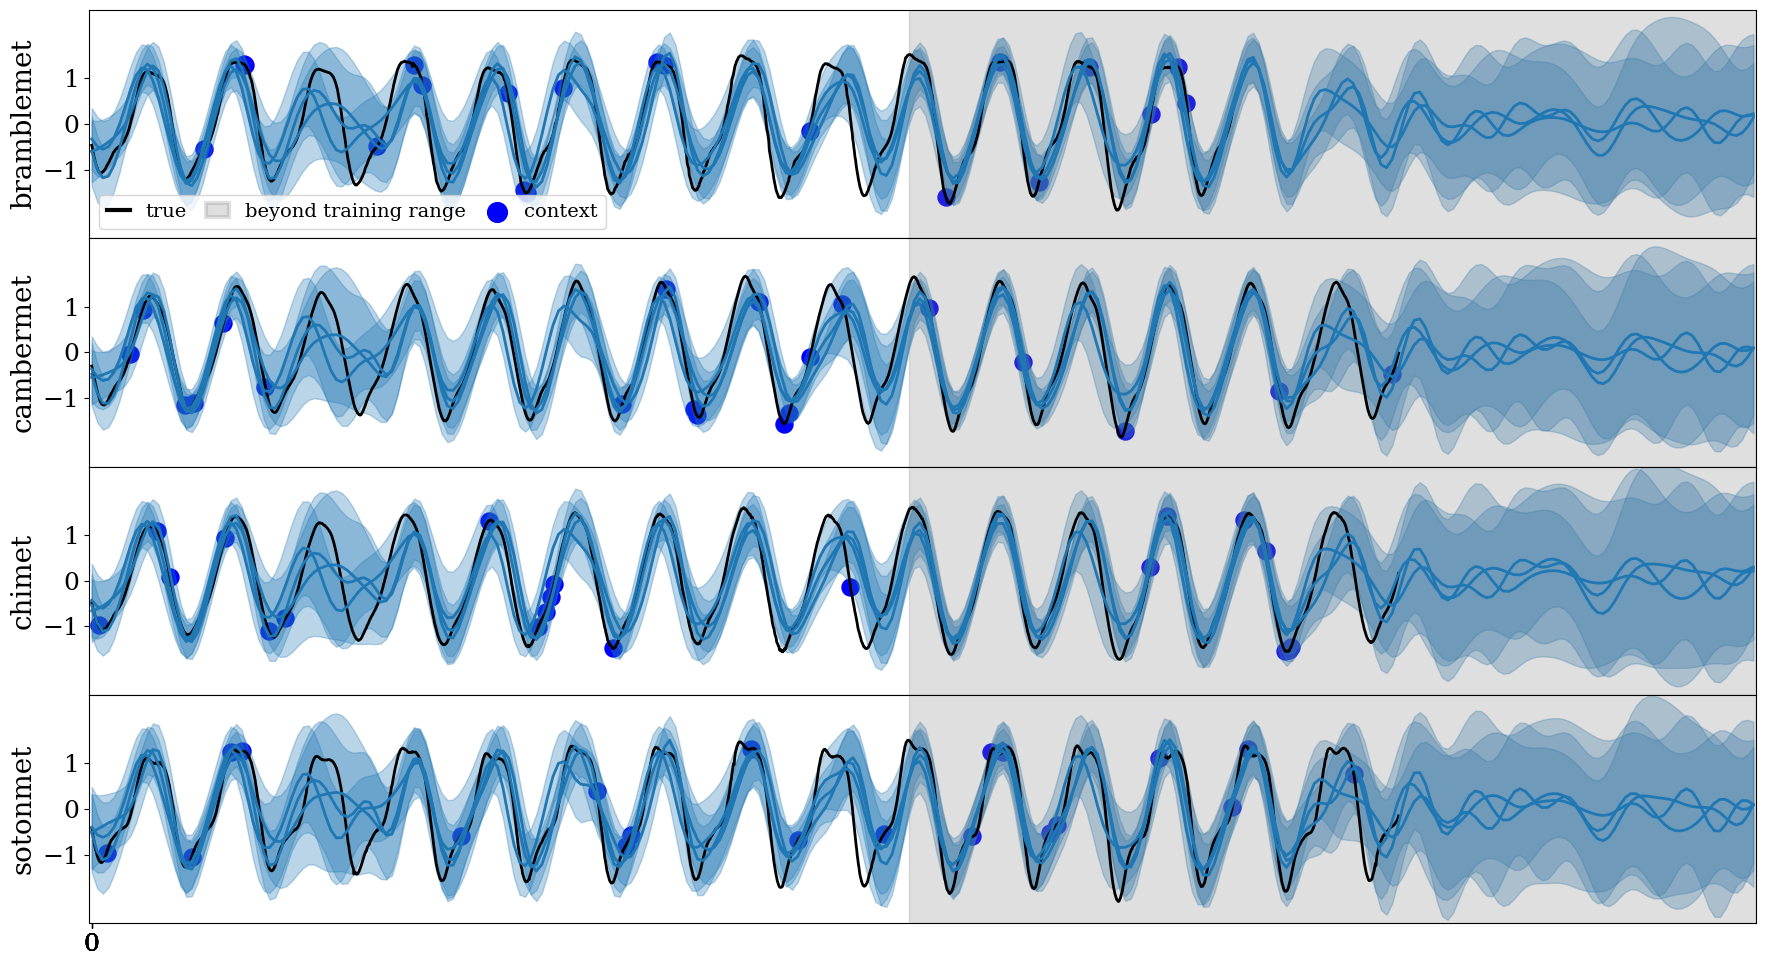

In [158]:
#xlim_ = [0,220]

#fig = plt.figure(figsize=figsiz_)
fig, axs = plt.subplots(num_channels, figsize=figsiz_, ncols=1, sharex=True , gridspec_kw={'hspace': 0})
#fig.subplots_adjust(top=0.95, bottom=0.05, left=0.17, right=0.845, wspace=0,hspace=0)
#fig.subplots_adjust( wspace=0,hspace=0)

for j in range(num_channels):

    axs[j].axvspan(xmin = n_time_split ,xmax = xlim_[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label='beyond training range')

    #dataset
    axs[j].scatter(context_x[:,j],context_y[:,j],color = 'b',label = 'context',s=150)
    #axs[j].scatter(target_x[:,j],target_y[:,j],color = 'b',label = 'target',s=100)
    axs[j].plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=2.)
    
    #outrain regeion    

#     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
#     plt.fill_between(target_x[:,j],
#                      y_mean[:,j] + 2 * y_std[:,j],
#                      y_mean[:,j] - 2 * y_std[:,j],
#                      color='tab:blue', alpha=0.4)

    if len(y_mean.shape)==2:
        axs[j].plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=2.0)
        axs[j].fill_between(full_x[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=0.4)

        
    if len(y_mean.shape)==3:
        for kk in range(3):
            axs[j].plot(full_x[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=2.0)
            axs[j].fill_between(full_x[:,j],
                             y_mean[kk,:,j] + 2 * y_std[kk,:,j],
                             y_mean[kk,:,j] - 2 * y_std[kk,:,j],
                             color='tab:blue', alpha=0.3)
        


    
    axs[j].set(xlim=xlim_,ylim=ylim_)
    #plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
    axs[j].set_ylabel('{}'.format(cols[j]),fontsize=fontsiz_+2)
    #plt.xlim(xlim_)
    axs[j].set_yticks(yticks_)


    
    if j == 0:
        leg = axs[j].legend(loc = 'lower left',fontsize=fontsiz_-4.,ncol=5,handlelength= 1.2, columnspacing =1.0)
        for ii in leg.legendHandles:
            ii.set_linewidth(3)      
        
    #plt.xticks(xticks_,fontsize=fontsiz_-2)
    #plt.xticks([],fontsize=fontsiz_-2)        
    if j==3:
        axs[j].set_xticks(xticks_)
    else:
        axs[j].set_xticks([])


    

fig.tight_layout()    
#plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
#plt.savefig(saved_model_path + modelspec + '_' + datatype + '_ch{}'.format(j)  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
#savefigname =  modelspec + '_' + datatype + '_ch{}'.format(j)
savefigname =  modelspec + '_' + datatype + '_full'

plt.savefig('./'  + savefigname   + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
    
    #plt.show()
#'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [159]:
transformed_ymean.shape
#y_mean.shape

(10, 300)

In [160]:
ylim_ = [0.0,6.]
yticks_ = [1,3,5]
fontsiz_ = 18


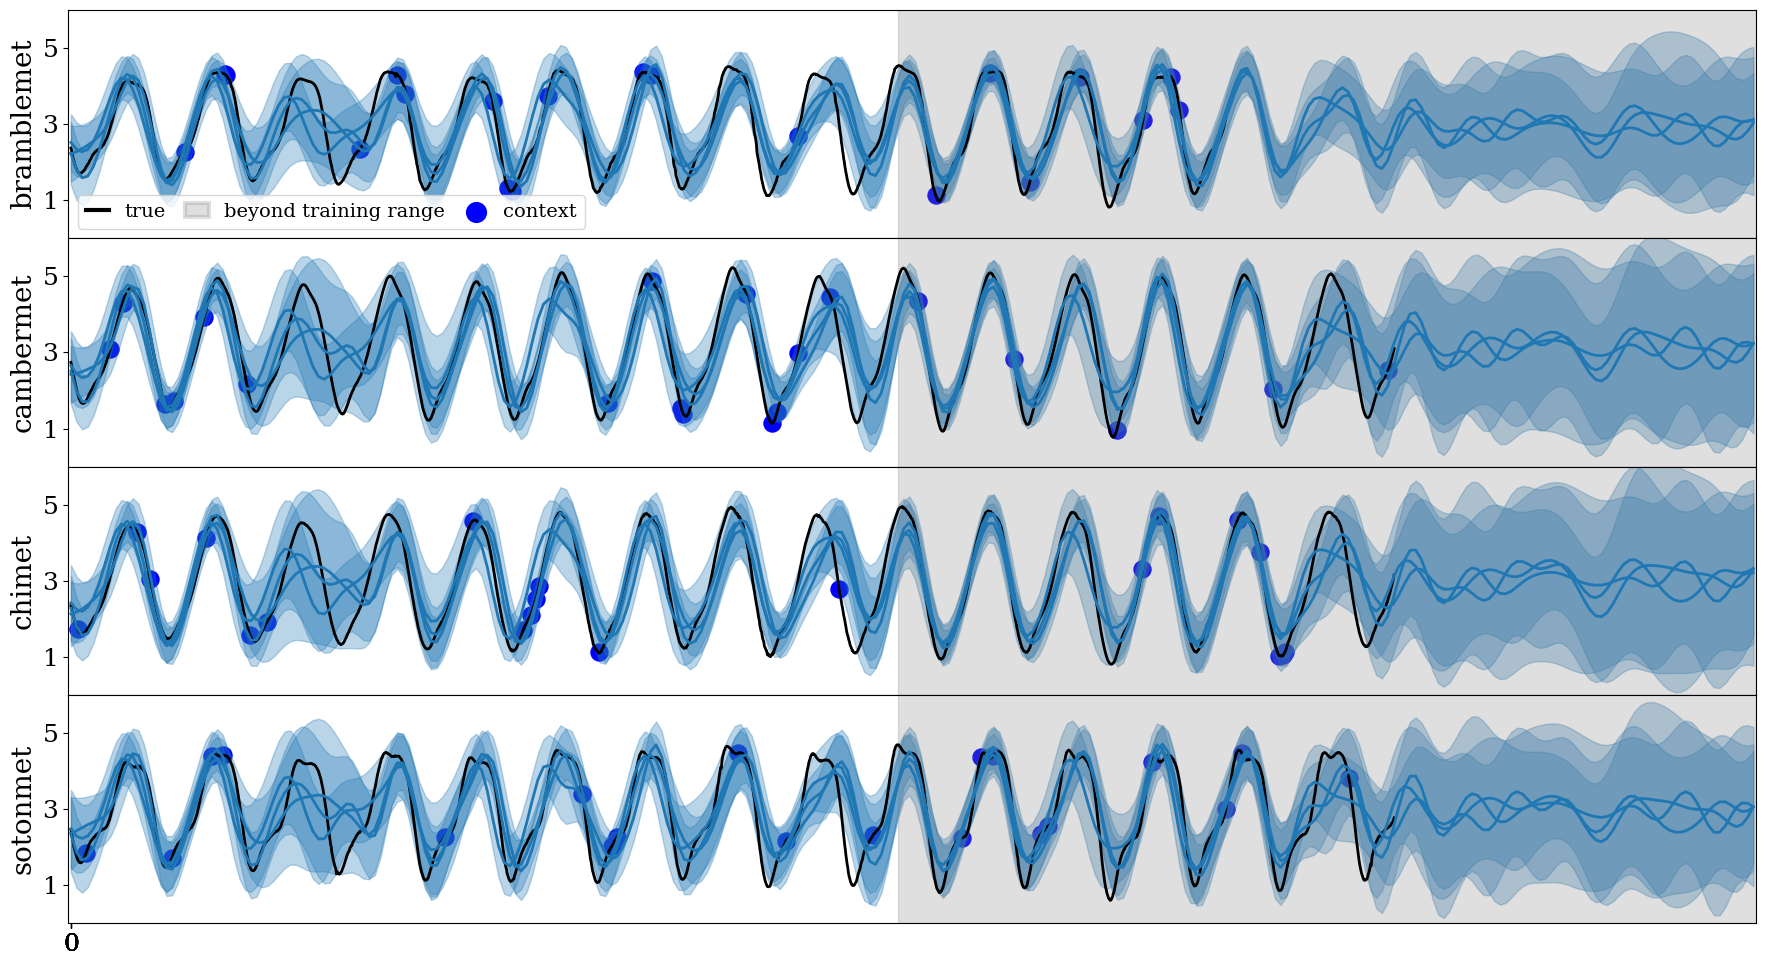

In [161]:
#xlim_ = [0,220]

#fig = plt.figure(figsize=figsiz_)
fig, axs = plt.subplots(num_channels, figsize=figsiz_, ncols=1, sharex=True , gridspec_kw={'hspace': 0})
#fig.subplots_adjust(top=0.95, bottom=0.05, left=0.17, right=0.845, wspace=0,hspace=0)
#fig.subplots_adjust( wspace=0,hspace=0)

for j in range(num_channels):
    #outrain regeion    
    axs[j].axvspan(xmin = n_time_split ,xmax = xlim_[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label='beyond training range')

    #dataset
    transformed_context_y = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*context_y[:,j]
    transformed_target_y = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*target_y[:,j]    
    transformed_y = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*dataset_dict[j]['y']
    
    #axs[j].scatter(target_x[:,j],target_y[:,j],color = 'b',label = 'target',s=100)

    
    axs[j].scatter(context_x[:,j],transformed_context_y,color = 'b',label = 'context',s=150)
    #axs[j].scatter(target_x[:,j],transformed_target_y,color = 'r',label = 'target',s=150)    
    axs[j].plot(dataset_dict[j]['x'],transformed_y,'k',label='true',linewidth=2.)
    


    
    if len(y_mean.shape)==2:
        transformed_ymean = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*y_mean[:,j]
        transformed_ystd = dataset_dict[j]['ystd']*y_std[:,j]
        
        
        axs[j].plot(full_x[:,j], transformed_ymean,color='tab:blue',linewidth=2.0)
        axs[j].fill_between(full_x[:,j],
                            transformed_ymean + 2 *  transformed_ystd,
                            transformed_ymean - 2 *  transformed_ystd,
                            color='tab:blue', alpha=0.4)

        
    if len(y_mean.shape)==3:
        transformed_ymean = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*y_mean[:,:,j]
        transformed_ystd = dataset_dict[j]['ystd']*y_std[:,:,j]
        
        
        for kk in range(3):
            axs[j].plot(full_x[:,j],transformed_ymean[kk,:],color='tab:blue',linewidth=2.0)
            axs[j].fill_between(full_x[:,j],
                                transformed_ymean[kk,:] + 2 * transformed_ystd[kk,:],
                                transformed_ymean[kk,:] - 2 * transformed_ystd[kk,:],
                                color='tab:blue', alpha=0.3)
        


    
    axs[j].set(xlim=xlim_,ylim=ylim_)
    #plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
    axs[j].set_ylabel('{}'.format(cols[j]),fontsize=fontsiz_+2)
    #plt.xlim(xlim_)
    axs[j].set_yticks(yticks_)


    
    if j == 0:
        leg = axs[j].legend(loc = 'lower left',fontsize=fontsiz_-4.,ncol=5,handlelength= 1.2, columnspacing =1.0)
        for ii in leg.legendHandles:
            ii.set_linewidth(3)      
        
    #plt.xticks(xticks_,fontsize=fontsiz_-2)
    #plt.xticks([],fontsize=fontsiz_-2)        
    if j==3:
        axs[j].set_xticks(xticks_)
    else:
        axs[j].set_xticks([])


    

fig.tight_layout()    
#plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
#plt.savefig(saved_model_path + modelspec + '_' + datatype + '_ch{}'.format(j)  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
#savefigname =  modelspec + '_' + datatype + '_ch{}'.format(j)
savefigname =  modelspec + '_' + datatype + '_full'
plt.show()
#plt.savefig('./'  + savefigname   + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
    
    #plt.show()
#'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [80]:

# xgrid = convcnp.compute_xgrid(xc.squeeze(),yc,xt.squeeze())
# _,nh1,h1,h0 = convcnp.encoder(xc.squeeze(),yc,xgrid.squeeze())


# fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9,hspace=0.00)
# # ax1.plot(xc[0,:,0,0].cpu().data.numpy(),yc[0,:,0].cpu().data.numpy(),color_list[0]+'o-',markersize=10,label='ch 1')
# # ax2.plot(xc[0,:,0,1].cpu().data.numpy(),yc[0,:,1].cpu().data.numpy(),color_list[1]+'o-',markersize=10,label='ch 2')

# ax1.scatter(xc[0,:,0,0].cpu().data.numpy(),yc[0,:,0].cpu().data.numpy(),color=color_list[0],marker='o',s=150)
# ax2.scatter(xc[0,:,0,1].cpu().data.numpy(),yc[0,:,1].cpu().data.numpy(),color=color_list[1],marker='o',s=150)
# ax1.plot(xf[0,:,0,0].cpu().data.numpy(),yf[0,:,0].cpu().data.numpy(),color_list[0]+'-',markersize=10,label='ch 1',alpha=0.5)
# ax2.plot(xf[0,:,0,1].cpu().data.numpy(),yf[0,:,1].cpu().data.numpy(),color_list[1]+'-',markersize=10,label='ch 2',alpha=0.5)

# #for j in range(numsamples):
#     #ax1.plot(xa_samples[0,:,0].cpu().data.numpy(),posterior_samples[0,j,:,0].cpu().data.numpy(),'k-'+'s',alpha=0.8,markersize=2)      
#     #ax2.plot(xa_samples[0,:,0].cpu().data.numpy(),posterior_samples[0,j,:,1].cpu().data.numpy(),'k-'+'s',alpha=0.8,markersize=2)      
# ax1.plot(xgrid[0,:,0].cpu().data.numpy(),nh1[0,:,0].cpu().data.numpy(),'k-',alpha=0.8,linewidth=2)      
# ax2.plot(xgrid[0,:,1].cpu().data.numpy(),nh1[0,:,1].cpu().data.numpy(),'k-',alpha=0.8,linewidth=2)      

    
# ax1.set(xlim=xlim_,ylim=ylim_)
# ax2.set(xlim=xlim_,ylim=ylim_)
# ax1.set_xticks(xtick_)
# ax2.set_xticks(xtick_)
# ax1.set_yticks(ytick_)
# ax2.set_yticks(ytick_)

# leg_pos = 'lower right'
# leg1= ax1.legend(loc=leg_pos ,fontsize=fontsiz,handlelength=.75,ncol=1)
# leg2= ax2.legend(loc=leg_pos ,fontsize=fontsiz,handlelength=.75,ncol=1)

# for line in leg1.get_lines():
#     line.set_linewidth(5) 
#     #line.set_markersize(4)
# for line in leg2.get_lines():
#     line.set_linewidth(5) 
#     #line.set_markersize(4)     

    
# # plt.xlim(xlim_)
# # plt.ylim(ylim_)

# savefigname = savepath + 'fig_base_nsamples{}_initl{}'.format(1,init_lscale)
# #plt.savefig(savefigname + fig_pdf, dpi=1000,bbox_inches='tight')
# savefigname














10

'[0.  0.6 1.2 1.8 2.4 3. ]'